In [1]:
from mylib.statistic_test import *
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from mazepy.datastruc.neuact import SpikeTrain
from mazepy.datastruc.variables import VariableBin

code_id = "0850 - Lisa Paper Revisits"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)


def get_lapwise_ratemap(trace: dict):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    smoothed_map = np.zeros((trace['n_neuron'], 144, beg_idx.shape[0]), dtype = np.float64)
    
    for i in range(beg_idx.shape[0]):
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = spike_nodes_transform(trace['spike_nodes_original'][spike_idx].astype(np.int64), 12)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        rate_map = spike_train.calc_tuning_curve(144, t_interv_limits=100)
        smoothed_map[:, :, i] = rate_map.to_array() #@ trace['Ms'].T
    
    bins = CP_DSP[3]-1
    smoothed_map = smoothed_map[:, bins, :]

    X = np.transpose(smoothed_map, (2, 1, 0))
    return X

def get_all_mice_data(mouse):
    file_indices = np.where(f2['MiceID'] == mouse)[0]
    cellreg_index = np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]
    
    traces = []
    for i in file_indices:
        with open(f2['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)
            traces.append(trace)

    with open(f_CellReg_dsp['cellreg_folder'][cellreg_index], 'rb') as handle:
        index_map = pickle.load(handle).astype(np.int64)
            
    if mouse != 10232:
        index_map = index_map[1:, :]
    
    # Identify neurons that appear in all sessions
    ncell = np.where(np.sum(np.where(index_map == 0, 0, 1), axis=0) == index_map.shape[0])[0]
    
    session_label = []
    route_label = []
    Xs = []
    centroid_init0 = []
    centroid_init1 = []
    for i, trace in enumerate(traces):
        X = get_lapwise_ratemap(trace)
        
        cent1 = trace[f'node 3']['old_map_clear'][index_map[i, ncell]-1, :][:, CP_DSP[3]-1].T.flatten()
        cent0 = np.vstack([trace[f'node {n}']['old_map_clear'][index_map[i, ncell]-1, :][:, CP_DSP[3]-1].T.flatten() for n in [0, 4, 5, 9]])
        cent0 = np.mean(cent0, axis=0)
        
        centroid_init0.append(cent0)
        centroid_init1.append(cent1)
        
        beg_time, end_time = trace['lap beg time'], trace['lap end time']
        beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
        Xs.append(X[:, :, index_map[i, ncell]-1])
        
        session_label.append(np.ones(X.shape[0])*i)
        route_label.append(routes)
    
    return np.concatenate(Xs, axis=0), np.concatenate(session_label), np.concatenate(route_label), [centroid_init0, centroid_init1]

        E:\Data\FinalResults\Dsp\0850 - Lisa Paper Revisits is already existed!


In [2]:
from sklearn.cluster import KMeans

def fit_kmeans(X, R: int, kmeans_init=None, is_return_model: bool = False):
    """
    Cluster Maps with KMeans model.
    
    Parameters
    ----------
    X : np.ndarray
        The entire map of this cell within this session.
        shape: (I x J x K) tensor of normalized firing rates
        
        I: Trials
        J: Spatial bins
        K: Neurons
    
    Returns
    -------
    U, V
    """
    X_wrap = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
    
    if kmeans_init is not None:
        kmean = KMeans(n_clusters=R, init=kmeans_init)
    else:
        kmean = KMeans(n_clusters=R)
        
    kmean.fit(X_wrap)
    
    U = np.zeros((X.shape[0], R))
    for i in range(X.shape[0]):
        U[i, kmean.labels_[i]] = 1
        
    V = kmean.cluster_centers_
    
    if R == 2 and is_return_model == False:
        nclusters = np.sum(U, axis=0)
        if nclusters[0] < nclusters[1]:
            print(f"{nclusters[0]} < {nclusters[1]}")
            U = U[:, [1, 0]]
            V = V[[1, 0], :]
    
    if is_return_model:
        return U, V, kmean
    else:
        return U, V

def fit_pca(X, n_components: int, kmeans_init=None):
    """
    Cluster Maps with KMeans model.
    
    Parameters
    ----------
    X : np.ndarray
        The entire map of this cell within this session.
        shape: (I x J x K) tensor of normalized firing rates
        
        I: Trials
        J: Spatial bins
        K: Neurons
        
    n_components: int
        Number of components to keep
    
    Returns
    -------
    reduced_X: np.ndarray
        The reduced map, shape: (I x n_components)
    """
    X_wrap = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
    
    pca = PCA(n_components=n_components)
    
    if kmeans_init is None:
        return pca.fit_transform(X_wrap)
    else:
        pca.fit(X_wrap)
        return pca.transform(X_wrap), pca.transform(kmeans_init)

def get_lap_distances(X, V):
    """
    Refer to 'Distance to cluster calculations' Section of Lisa paper.
    
    Parameters
    ----------
    X: ndarray (I x J x K) tensor of normalized firing rates
        I: Trials/Laps
        J: Position Bins
        K: Neurons
    V: ndarray, low-dimensional factors (R x JK)
        R: Rank, which is 2 here
    
    Returns
    -------
    Distances: ndarray, distances to cluster centers (I x R), for each position
    in each lap.
    """
    I, J, K = X.shape
    V = V.reshape(2, J, K)
    
    Distances = np.zeros(I)
    
    for i in range(I):
        Distances[i] = (
            np.sum(
                (2 * X[i, :, :] - (V[0, :, :] + V[1, :, :])) * 
                (V[0, :, :] - V[1, :, :])
            ) / 
            np.sum((V[0, :, :] - V[1, :, :])**2)
        )
            
    return Distances

def get_lap_neuron_distances(X, V):
    """
    Refer to 'Distance to cluster calculations' Section of Lisa paper.
    
    Parameters
    ----------
    X: ndarray (I x J x K) tensor of normalized firing rates
        I: Trials/Laps
        J: Position Bins
        K: Neurons
    V: ndarray, low-dimensional factors (R x JK)
        R: Rank, which is 2 here
    
    Returns
    -------
    Distances: ndarray, distances to cluster centers (I x R), for each neuron
    in each lap.
    and 
    """
    I, J, K = X.shape
    V = V.reshape(2, J, K)
    
    Distances = np.zeros((I, K))
    
    for i in range(I):
        for k in range(K):
            Distances[i, k] = (
                np.sum(
                    (2 * X[i, :, k] - (V[0, :, k] + V[1, :, k])) * 
                    (V[0, :, k] - V[1, :, k])
                ) / 
                np.sum((V[0, :, k] - V[1, :, k])**2)
            )
            
    return Distances

def _convert_pos_to_idx(P):
    converting_array = np.zeros(144)-1
    for i, pos in enumerate(CP_DSP[3]):
        converting_array[pos-1] = i
        
    return converting_array[P-1].astype(np.int64)

def get_lap_pos_distances(X, P, V):
    """
    Refer to 'Distance to cluster calculations' Section of Lisa paper.
    
    Parameters
    ----------
    X: ndarray (N x T) matrix of firing rates, i.e., neural trajectory
        N: Neurons
        T: Time bins
    P: ndarray (T, ) array of positions, corresponding to each time bin.
    
    V: ndarray, low-dimensional factors (R x JK)
        R: Rank, which is 2 here
    
    Returns
    -------
    Distances: ndarray, distances to cluster centers (I x R), for each position
    in each lap.
    """
    N, T = X.shape
    V = V.reshape(2, CP_DSP[3].shape[0], N)
    
    P = _convert_pos_to_idx(P)
    
    kmeans_dist_traj = np.zeros(T)
    
    for t in range(T):
        if P[t] == -1:
            kmeans_dist_traj[t] = np.nan
            continue
        """
        projection = np.dot(X[:, t] - (V[0, P[t], :] + V[1, P[t], :]) / 2, V[0, P[t], :] - V[1, P[t], :])
        projection /= np.linalg.norm(V[0, P[t], :] - V[1, P[t], :])**2
        kmeans_dist_traj[t] = projection
        """
        kmeans_dist_traj[t] = (
            np.sum(
                (2 * X[:, t] - (V[0, P[t], :] + V[1, P[t], :])) * 
                (V[0, P[t], :] - V[1, P[t], :])
            ) / 
            np.sum((V[0, P[t], :] - V[1, P[t], :])**2)
        )
        
    return kmeans_dist_traj


def plot_lapwise_distances(X, session_label, route_label, mouse, kmeans_init = None):
    U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)
    print(np.where(V<0)[0].shape[0])
    distances = get_lap_distances(X, V)

    y_max = 2
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(7, 4))
    for i in range(7):
        ax = Clear_Axes(axes[i], close_spines=['left', 'top', 'right'], ifxticks=True)
        idx = np.where(session_label == i)[0]
        ax.plot(
            distances[idx],
            np.arange(idx.shape[0]), 
            linewidth=0.5,
            color='#B5B5B6' #gray
        )
        idx0 = np.where(
            distances[idx] > 0
        )[0]
        idx1 = np.where(
            distances[idx] < 0
        )[0]
        ax.plot( 
            distances[idx][idx0], 
            np.arange(idx.shape[0])[idx0],
            's',
            markeredgewidth=0,
            markersize=2.5,
            linewidth=0.5,
            color='#28306E'
        )
        ax.plot(
            distances[idx][idx1], 
            np.arange(idx.shape[0])[idx1],
            's',
            markeredgewidth=0,
            markersize=2.5,
            linewidth=0.5,
            color='#A2C78D'
        )
    
        for j in range(7):
            idxr = np.where(route_label[idx] == j)[0]
            ax.plot(
                np.repeat(2.4, idxr.shape[0]),
                np.arange(idx.shape[0])[idxr], 
                's',
                markeredgewidth=0,
                markersize=3,
                color=DSPPalette[j]
            )
    
        dl = np.where(np.ediff1d(route_label[idx]) != 0)[0] + 0.5
        for d in dl:
            ax.axhline(d, color='k', linewidth=0.1, ls='--')
    
        ax.axvline(0, color='k', linewidth=0.1, ls='--')
        ax.set_xlim([y_max+0.5, -y_max])
        ax.set_xticks(np.linspace(-2, 2, 5)) 
    plt.savefig(join(loc, f"DistanceToCluster {mouse}.png"), dpi = 600)
    plt.savefig(join(loc, f"DistanceToCluster {mouse}.svg"), dpi = 600)
    plt.show()

def hex_to_rgba(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-255).
    """
    hex_color = hex_color.lstrip('#')  # Remove '#' if present
    if len(hex_color) == 6:
        r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
        a = 255  # Default alpha
    elif len(hex_color) == 8:
        r, g, b, a = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16), int(hex_color[6:8], 16)
    else:
        raise ValueError("Invalid hex color format. Use #RRGGBB or #RRGGBBAA.")
    return r, g, b, a

def hex_to_rgba_normalized(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-1).
    """
    r, g, b, a = hex_to_rgba(hex_color)
    return np.array([r / 255, g / 255, b / 255, a / 255])

DSPPaletteRGBA = np.vstack([hex_to_rgba_normalized(c) for c in DSPPalette])
DayPaletteRGBA = np.asarray(sns.color_palette("rainbow", 7))
MAPPaletteRGBA = np.vstack([hex_to_rgba_normalized(c) for c in ['#333766', '#A4C096']])

def plot_pca_clusters(X, session_label, route_label, mouse, map_identity, kmeans_init = None):
    if kmeans_init is None:
        reduced_X = fit_pca(X, 2)
    else:
        reduced_X, reduced_centroids = fit_pca(X, 2, kmeans_init=kmeans_init)
        
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(3, 9))
    ax0, ax1, ax2 = (
        Clear_Axes(axes[0], close_spines=['top', 'right']), 
        Clear_Axes(axes[1], close_spines=['top', 'right']), 
        Clear_Axes(axes[2], close_spines=['top', 'right'])
    )
    ax0.scatter(
        reduced_X[:, 0],
        reduced_X[:, 1],
        s=5,
        color=DSPPaletteRGBA[route_label, :],
        alpha=0.9
    )
    ax1.scatter(
        reduced_X[:, 0],
        reduced_X[:, 1],
        s=5,
        alpha=0.9,
        color=DayPaletteRGBA[session_label.astype(np.int64), :]
    )
    
    if kmeans_init is not None:
        ax0.scatter(
            reduced_centroids[:, 0],
            reduced_centroids[:, 1],
            s=10,
            color=MAPPaletteRGBA
        )
        ax1.scatter(
            reduced_centroids[:, 0],
            reduced_centroids[:, 1],
            s=10,
            color=MAPPaletteRGBA
        )
        
    ax0.set_aspect("equal")
    ax1.set_aspect("equal")
    # Blues correspond to Session 0 while reds correspond to Session 6
    ax2.scatter(
        reduced_X[:, 0],
        reduced_X[:, 1],
        s=5,
        color=MAPPaletteRGBA[map_identity.astype(np.int64), :],
        alpha=0.9
    )
    ax2.set_aspect("equal")
    plt.savefig(join(loc, f"PCA Clusters {mouse}.png"), dpi = 600)
    plt.savefig(join(loc, f"PCA Clusters {mouse}.svg"), dpi = 600)
    plt.show()

In [3]:
with open(join(loc, f"{10212}.pkl"), "rb") as f:
    X, session_label, route_label, kmeans_init = pickle.load(f)
print(X.shape)

(549, 27, 118)


# Identify if Two Maps demonstrate data best

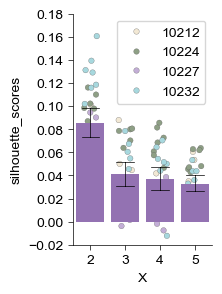

  Mean: 0.08575400616014188, STD: 0.03498278701680878, Max: 0.16060504796062286, Min: 0.02474249612493958, Median: 0.09231574564010059, df: 27
  Mean: 0.04113001983729747, STD: 0.02701236653388593, Max: 0.08792687503445322, Min: -0.0037973262276869662, Median: 0.0363977611641262, df: 27
TtestResult(statistic=6.530386064646588, pvalue=5.296885684212311e-07, df=27)


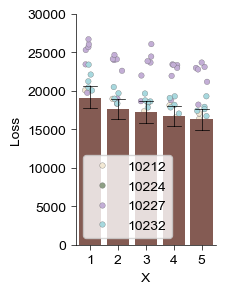

  Mean: 19097.17705864703, STD: 3756.5652835948117, Max: 26681.38241978974, Min: 14067.469319560534, Median: 17963.358949328613, df: 27
  Mean: 17645.59196002544, STD: 3559.035807878876, Max: 24646.490926400566, Min: 12774.865382591095, Median: 16820.477007505364, df: 27
  Mean: 17241.703707468874, STD: 3800.33401088026, Max: 26054.939248470637, Min: 12147.723834350203, Median: 15999.981269175718, df: 27
TtestResult(statistic=-13.545573460368054, pvalue=1.4786427968127594e-13, df=27)
TtestResult(statistic=3.61563361061007, pvalue=0.0012118704175404823, df=27)

D Loss
  Mean: 1451.585098621589, STD: 556.8355927518235, Max: 2909.7910255255047, Min: 654.9990546004483, Median: 1449.92776596779, df: 27
  Mean: 403.88825255656747, STD: 580.4418113234781, Max: 1617.1539868672135, Min: -1408.4483220700713, Median: 520.0503938425009, df: 27
TtestResult(statistic=6.332823925517884, pvalue=8.844572701928314e-07, df=27)
TtestResult(statistic=-0.4335930383190982, pvalue=0.6680287207383837, df=27)


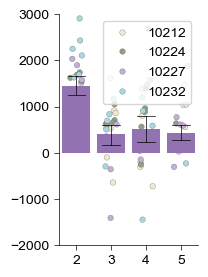

In [3]:

from sklearn.metrics import silhouette_score
def select_best_rank(X, session_label, max_rank: int, kmeans_init='k-means++'):
    """
    Uses silhouette_scores to select the best rank R for low-rank matrix factorization.

    Parameters:
        X: ndarray (I x J x K) tensor of normalized firing rates
        k_clusters: int, number of clusters
        max_rank: int, maximum rank R to test

    Returns:
        best_R: int, the rank R with the lowest silhouette_scores score
        silhouette_scores: list, silhouette_scores scores for each tested rank
    """
    I, J, K = X.shape
    n = I  # Number of samples (rows in U_continuous)
    silhouette_scores = np.zeros((7, max_rank))
    average_loss = np.zeros((7, max_rank))

    for rank_R in range(1, max_rank + 1):
        X_wrap = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
        for i in range(7):
            if rank_R == 2:
                U, V, kmeans = fit_kmeans(
                    X[session_label == i, :, :], rank_R, 
                    kmeans_init=kmeans_init, 
                    is_return_model=True
                )
            else:
                U, V, kmeans = fit_kmeans(
                    X[session_label == i, :, :], 
                    rank_R, 
                    is_return_model=True
                )

            loss = np.mean(np.sum(np.square(X_wrap[session_label == i, :] - U @ V), axis=1))
            average_loss[i, rank_R - 1] = loss
        
            if rank_R == 1:
                silhouette_scores[i, rank_R - 1] = np.nan
                continue
            
            labels = kmeans.labels_
    
            silhouette_scores[i, rank_R - 1] = silhouette_score(
                X_wrap[session_label == i, :], 
                labels
            )
       
    return silhouette_scores.flatten(), average_loss.flatten()

if exists(join(figdata, f"{code_id} [silhouette_scores].pkl")) == False:
    EffData = {
        "MiceID": [],
        "Session": [],
        "Loss": [],
        "X": [],
        "silhouette_scores": []
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        if exists(join(loc, f"{mouse}.pkl")) == False:
            X, session_label, route_label, kmeans_init = get_all_mice_data(mouse)
            
            with open(join(loc, f"{mouse}.pkl"), "wb") as f:
                pickle.dump([X, session_label, route_label, kmeans_init], f)
        else:
            with open(join(loc, f"{mouse}.pkl"), "rb") as f:
                X, session_label, route_label, kmeans_init = pickle.load(f)
        
        kmeans_init = np.vstack([np.mean(i, axis=0) for i in kmeans_init])
        silhouette_scores, average_loss = select_best_rank(X, session_label, 5, kmeans_init=kmeans_init)
        EffData["MiceID"].append(np.repeat(mouse, 5 * 7))
        EffData["X"].append(np.concatenate([np.arange(1, 6)] * 7))
        EffData["silhouette_scores"].append(silhouette_scores)
        EffData["Loss"].append(average_loss)
        EffData["Session"].append(np.repeat([1, 2, 3, 4, 5], 7))
        
        #U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)
        #plot_lapwise_distances(X, session_label, route_label, mouse, kmeans_init=kmeans_init)
        #plot_pca_clusters(X, session_label, route_label, mouse, U[:, 1])
        
    for k in EffData.keys():
        EffData[k] = np.concatenate(EffData[k])
        
    with open(join(figdata, f"{code_id} [silhouette_scores].pkl"), "wb") as f:
        pickle.dump(EffData, f)
        
    EffD = pd.DataFrame(EffData)
    EffD.to_excel(join(figdata, f"{code_id} [silhouette_scores].xlsx"), index = False)
else:
    with open(join(figdata, f"{code_id} [silhouette_scores].pkl"), "rb") as f:
        EffData = pickle.load(f)
        
fig = plt.figure(figsize=(1.8, 3))
SubData = SubDict(EffData, EffData.keys(), np.where(EffData['X'] != 1)[0])
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'X',
    y='silhouette_scores',
    data=SubData,
    hue='MiceID',
    palette = ['#F2E8D4', '#8E9F85', '#C3AED6', '#A7D8DE'],
    size = 4,
    linewidth=0.2,
    jitter=0.2,
    ax = ax,
    zorder=1
)
sns.barplot(
    x = 'X',
    y='silhouette_scores',
    data=SubData,
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    width=0.8,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
ax.set_ylim(-0.02, 0.18)
ax.set_yticks(np.linspace(-0.02, 0.18, 11))
plt.savefig(join(loc, "silhouette_scores.png"), dpi=600)
plt.savefig(join(loc, "silhouette_scores.svg"), dpi=600)
plt.show()

idx1 = np.where(EffData["X"] == 1)[0]
idx2 = np.where(EffData["X"] == 2)[0]
idx3 = np.where(EffData["X"] == 3)[0]
print_estimator(EffData["silhouette_scores"][idx2])
print_estimator(EffData["silhouette_scores"][idx3])
print(ttest_rel(EffData["silhouette_scores"][idx2], EffData["silhouette_scores"][idx3]))

fig = plt.figure(figsize=(1.8, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'X',
    y='Loss',
    data=EffData,
    hue='MiceID',
    palette = ['#F2E8D4', '#8E9F85', '#C3AED6', '#A7D8DE'],
    size = 4,
    linewidth=0.2,
    jitter=0.2,
    ax = ax,
    zorder=1
)
sns.barplot(
    x = 'X',
    y='Loss',
    data=EffData,
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    width=0.8,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
ax.set_ylim(0, 30000)
plt.savefig(join(loc, "Loss.png"), dpi=600)
plt.savefig(join(loc, "Loss.svg"), dpi=600)
plt.show()

print_estimator(EffData["Loss"][idx1])
print_estimator(EffData["Loss"][idx2])
print_estimator(EffData["Loss"][idx3])
print(ttest_rel(EffData["Loss"][idx2], EffData["Loss"][idx1]))
print(ttest_rel(EffData["Loss"][idx2], EffData["Loss"][idx3]), end='\n\n')

x, y, m = [], [], []
for i in range(2, 6):
    idxa = np.where(EffData["X"] == i-1)[0]
    idxb = np.where(EffData["X"] == i)[0]
    x.append(np.repeat(i, idxa.shape[0]))
    y.append(EffData["Loss"][idxa] - EffData["Loss"][idxb])
    m.append(EffData["MiceID"][idxa])
    
print("D Loss")
print_estimator(y[0])
print_estimator(y[1])
print(ttest_rel(y[0], y[1]))
print(ttest_rel(y[1], y[2]))
x, y, m = np.concatenate(x), np.concatenate(y), np.concatenate(m)

fig = plt.figure(figsize=(1.8, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = x,
    y= y,
    hue=m,
    palette = ['#F2E8D4', '#8E9F85', '#C3AED6', '#A7D8DE'],
    size = 4,
    linewidth=0.2,
    jitter=0.2,
    ax = ax,
    zorder=1
)
sns.barplot(
    x = x,
    y= y,
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    width=0.8,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
ax.set_ylim(-2000, 3000)
ax.set_yticks(np.linspace(-2000, 3000, 6))
plt.savefig(join(loc, "Loss_diff.png"), dpi=600)
plt.savefig(join(loc, "Loss_diff.svg"), dpi=600)
plt.show()



# Identify Map Cross Day Stability

e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

549 467.0 82.0


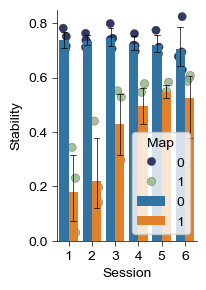

Cross Map Comparison
Session 1->2:  TtestResult(statistic=9.700447204175864, pvalue=0.0023266178023228254, df=3)
  Mean: 0.18003964142346096, STD: 0.11811553805889409, Max: 0.34323735604029576, Min: 0.02955728523822505, Median: 0.1736819622076615, df: 3

Session 2->3:  TtestResult(statistic=7.039243331146041, pvalue=0.005891243745198667, df=3)
  Mean: 0.21981629741050585, STD: 0.131776119992912, Max: 0.44032173943369723, Min: 0.10115664395571677, Median: 0.1688934031263047, df: 3

Session 3->4:  TtestResult(statistic=6.035592570271961, pvalue=0.009119577053490662, df=3)
  Mean: 0.4280506216928195, STD: 0.11321088375466726, Max: 0.5514794664981677, Min: 0.2956140182583366, Median: 0.4325545010073867, df: 3

Session 4->5:  TtestResult(statistic=6.669734362124073, pvalue=0.006871799418706095, df=3)
  Mean: 0.4950757550951385, STD: 0.06871203985682753, Max: 0.5778362416224249, Min: 0.4130264106749768, Median: 0.49472018404157614, df: 3

Session 5->6:  TtestResult(statistic=5.47902608528205

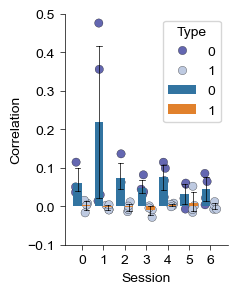

  Mean: 0.07893812021376603, STD: 0.10048451533823177, Max: 0.47575240980191236, Min: -0.007259952957973108, Median: 0.049853540461059775, df: 27
TtestResult(statistic=4.059124913726207, pvalue=0.00037842261654663325, df=27)

Map 1 vs. Map 2 - Across Day
F_onewayResult(statistic=1.824268678689883, pvalue=0.14276840179772965)


In [5]:
def get_cross_day_stability(mouse):
    if exists(join(loc, f"{mouse}.pkl")) == False:
        X, session_label, route_label, kmeans_init = get_all_mice_data(mouse)
        
        with open(join(loc, f"{mouse}.pkl"), "wb") as f:
            pickle.dump([X, session_label, route_label, kmeans_init], f)
    else:
        with open(join(loc, f"{mouse}.pkl"), "rb") as f:
            X, session_label, route_label, kmeans_init = pickle.load(f)
    
    kmeans_init = np.vstack([
        np.mean(i, axis=0) for i in kmeans_init
    ])
    US, VS = [], []
    for i in range(7):
        U, V = fit_kmeans(X[session_label == i, :, :], 2, kmeans_init=kmeans_init)
        US.append(U)
        VS.append(V)
    
    A = np.concatenate(US, axis=0)
    print(A.shape[0], np.sum(A[:, 0]), np.sum(A[:, 1]))
    
    stability = np.zeros((2, 6))
    for i in range(6):
        stability[0, i] = np.corrcoef(VS[i][0, :], VS[i+1][0, :])[0, 1]
        stability[1, i] = np.corrcoef(VS[i][1, :], VS[i+1][1, :])[0, 1]
    return stability.T

get_cross_day_stability(10212)

def get_cross_map_correlation(mouse):
    if exists(join(loc, f"{mouse}.pkl")) == False:
        X, session_label, route_label, kmeans_init = get_all_mice_data(mouse)
        
        with open(join(loc, f"{mouse}.pkl"), "wb") as f:
            pickle.dump([X, session_label, route_label, kmeans_init], f)
    else:
        with open(join(loc, f"{mouse}.pkl"), "rb") as f:
            X, session_label, route_label, kmeans_init = pickle.load(f)
    
    kmeans_init = np.vstack([
        np.mean(i, axis=0) for i in kmeans_init
    ])
    US, VS = [], []
    for i in range(7):
        U, V = fit_kmeans(X[session_label == i, :, :], 2, kmeans_init=kmeans_init)
        US.append(U)
        VS.append(V)
        
    stability = np.zeros(14)
    for i in range(7):
        stability[i] = np.corrcoef(VS[i][0, :], VS[i][1, :])[0, 1]
        stability[i+7] = np.corrcoef(VS[i][0, :], VS[i][1, np.random.permutation(VS[i][0, :].shape[0])])[0, 1]
        
        
    return stability

if exists(join(figdata, f"{code_id} [cross_day_stability].pkl")) == False:
    StabData = {
        "MiceID": [],
        "Stability": [],
        "Session": [],
        "Map": [],
    }
    
    BetCorrData = {
        "MiceID": [],
        "Correlation": [],
        "Session": [],
        "Type": []
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        stability = get_cross_day_stability(mouse)
        StabData["MiceID"].append(np.repeat(mouse, 12))
        StabData["Stability"].append(stability.flatten())
        StabData["Session"].append(np.repeat([1, 2, 3, 4, 5, 6], 2))
        StabData["Map"].append(np.concatenate([np.array([0, 1])]*6))
        
        corr = get_cross_map_correlation(mouse)
        BetCorrData["MiceID"].append(np.repeat(mouse, 14))
        BetCorrData["Correlation"].append(corr)
        BetCorrData["Session"].append(np.concatenate([np.arange(7), np.arange(7)]))
        BetCorrData["Type"].append(np.concatenate([np.repeat(0, 7), np.repeat(1, 7)]))
        
    for k in StabData.keys():
        StabData[k] = np.concatenate(StabData[k])
    
    for k in BetCorrData.keys():
        BetCorrData[k] = np.concatenate(BetCorrData[k])
        
    with open(join(figdata, f"{code_id} [cross_day_stability].pkl"), "wb") as f:
        pickle.dump(StabData, f)
        
    with open(join(figdata, f"{code_id} [cross_map_correlation].pkl"), "wb") as f:
        pickle.dump(BetCorrData, f)
        
    StabD = pd.DataFrame(StabData)
    StabD.to_excel(join(figdata, f"{code_id} [cross_day_stability].xlsx"), index = False)
    
    BetCorrD = pd.DataFrame(BetCorrData)
    BetCorrD.to_excel(join(figdata, f"{code_id} [cross_map_correlation].xlsx"), index = False)
    
    print(len(StabD), len(BetCorrD))
else:
    with open(join(figdata, f"{code_id} [cross_day_stability].pkl"), "rb") as f:
        StabData = pickle.load(f)
        
    with open(join(figdata, f"{code_id} [cross_map_correlation].pkl"), "rb") as f:
        BetCorrData = pickle.load(f)
        
fig = plt.figure(figsize=(1.8, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'Session',
    y='Stability',
    data=StabData,
    hue='Map',
    palette = ['#333766', '#A4C096'],
    size = 6,
    linewidth=0.2,
    dodge=True,
    jitter=0.2,
    ax = ax,
    zorder=1
)

sns.barplot(
    x = 'Session',
    y='Stability',
    data=StabData,
    hue='Map',
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    width=0.8,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
ax.set_ylim(0, 0.85)
plt.savefig(join(loc, "Cross Day Stability.png"), dpi=600)
plt.savefig(join(loc, "Cross Day Stability.svg"), dpi=600)
plt.show()

print("Cross Map Comparison")
for s in range(1, 7):
    res = ttest_rel(
        StabData['Stability'][np.where((StabData['Session'] == s) & (StabData['Map'] == 0))[0]],
        StabData['Stability'][np.where((StabData['Session'] == s) & (StabData['Map'] == 1))[0]]
    )
    print(f"Session {s}->{s+1}:  {res}")
    print_estimator(StabData['Stability'][np.where((StabData['Session'] == s) & (StabData['Map'] == 1))[0]], end='\n\n')

print("Map 0 Stability Overall:")
print_estimator(StabData['Stability'][np.where((StabData['Map'] == 0))[0]])

map_stab0 = [
    StabData['Stability'][np.where((StabData['Session'] == s) & (StabData['Map'] == 0))[0]] for s in range(1, 7)
]
map_stab1 = [
    StabData['Stability'][np.where((StabData['Session'] == s) & (StabData['Map'] == 1))[0]] for s in range(1, 7)
]

print("\nCross Day Comparison")
print(f"  Map 0: {f_oneway(*map_stab0)}")
print(f"  Map 1: {f_oneway(*map_stab1)}")


fig = plt.figure(figsize=(2.1, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'Session',
    y = 'Correlation',
    data=BetCorrData,
    hue='Type',
    palette = ['#6467b1', '#becae1'],
    size = 6,
    linewidth=0.2,
    dodge=True,
    jitter=0.2,
    edgecolor='k',
    ax = ax,
    zorder=1
)

sns.barplot(
    x = 'Session',
    y = 'Correlation',
    data=BetCorrData,
    hue='Type',
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    width=0.8,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
ax.set_ylim(-0.1, 0.5)
ax.set_xlim(-0.8, 6.8)
plt.savefig(join(loc, "Cross Map Correlation.png"), dpi=600)
plt.savefig(join(loc, "Cross Map Correlation.svg"), dpi=600)
plt.show()

idx0 = np.where(BetCorrData['Type'] == 0)[0]
idx1 = np.where(BetCorrData['Type'] == 1)[0]
print_estimator(BetCorrData['Correlation'][idx0])
print(ttest_rel(BetCorrData['Correlation'][idx0], BetCorrData['Correlation'][idx1]), end='\n\n')

print("Map 1 vs. Map 2 - Across Day")
map_stab2 = [
    BetCorrData['Correlation'][np.where((BetCorrData['Session'] == s) & (BetCorrData['Type'] == 0))[0]] for s in range(7)
]
print(f_oneway(*map_stab2))

# Transient Map Identification

In [5]:
import scipy.stats

dir_name = join(figpath, "Dsp", "0844 - Manifold of Initialization")

def get_transient_map(mouse: int):
    if exists(join(loc, f"transient_{mouse}.pkl")):
        with open(join(loc, f"transient_{mouse}.pkl"), "rb") as f:
            return pickle.load(f)
    
    with open(join(dir_name, f"{mouse}.pkl"), 'rb') as handle:
        _, session_traj, _, dists, route_traj, lap_traj, pos_traj, speed_traj, _, _, _, _, _, neural_traj = pickle.load(handle)

    if exists(join(loc, f"{mouse}.pkl")) == False:
        X, session_label, route_label, kmeans_init = get_all_mice_data(mouse)
        
        with open(join(loc, f"{mouse}.pkl"), "wb") as f:
            pickle.dump([X, session_label, route_label, kmeans_init], f)
    else:
        with open(join(loc, f"{mouse}.pkl"), "rb") as f:
            X, session_label, route_label, kmeans_init = pickle.load(f)
    
    kmeans_init = np.vstack([
        np.mean(i, axis=0) for i in kmeans_init
    ])
    US, VS = [], []
    for i in range(7):
        U, V = fit_kmeans(
            X[session_label == i, :, :], 
            2,
            kmeans_init=kmeans_init
        )
        US.append(U)
        VS.append(V)
    
    old_pos_traj = spike_nodes_transform(pos_traj+1, 12).astype(np.int64)
    idx = np.where(np.isin(old_pos_traj, CP_DSP[3]))[0]
    
    session_traj = session_traj[idx]
    old_pos_traj = old_pos_traj[idx]
    route_traj = route_traj[idx]
    lap_traj = lap_traj[idx]
    pos_traj = pos_traj[idx]
    speed_traj = speed_traj[idx]
    neural_traj = neural_traj[:, idx]
    dists = dists[idx]
    
    kmeans_dist_traj = []
    for i in range(7): 
        session_indices = np.where(session_traj == i)[0]
        dist_traj = get_lap_pos_distances(
            neural_traj[:, session_indices], 
            old_pos_traj[session_indices],
            VS[i]
        )
        kmeans_dist_traj.append(dist_traj)
    
    kmeans_dist_traj = np.concatenate(kmeans_dist_traj)
    
    print(kmeans_dist_traj.shape, neural_traj.shape)
    
    with open(join(loc, f"transient_{mouse}.pkl"), "wb") as f:
        pickle.dump([
                kmeans_dist_traj, 
                neural_traj, 
                session_traj, 
                old_pos_traj, 
                route_traj, 
                lap_traj, 
                pos_traj, 
                speed_traj,
                dists
            ], 
            f
        )
    return (
        kmeans_dist_traj, 
        neural_traj, 
        session_traj, 
        old_pos_traj, 
        route_traj, 
        lap_traj, 
        pos_traj, 
        speed_traj,
        dists
    )

vmin, vmax = 0,  7
_range = 5

def get_speed_dist_mat(mouse, session = None, is_shuffle: bool = False):
    (
        kmeans_dist_traj, 
        neural_traj, 
        session_traj, 
        old_pos_traj, 
        route_traj, 
        lap_traj, 
        pos_traj, 
        speed_traj,
        dists
    ) = get_transient_map(mouse)

    if is_shuffle:
        idx0 = np.arange(kmeans_dist_traj.shape[0])#np.random.permutation(speed_traj.shape[0])
        kmeans_dist_traj = np.roll(kmeans_dist_traj, np.random.randint(speed_traj.shape[0]))
        speed_traj = speed_traj[idx0]
    else:
        idx0 = np.arange(kmeans_dist_traj.shape[0])
        idx1 = np.arange(kmeans_dist_traj.shape[0])

    idx = np.where(np.ediff1d(lap_traj) == 0)[0]

    if session is None:
        return scipy.stats.binned_statistic_2d(
                x=speed_traj[:-1][idx],
                y=kmeans_dist_traj[:-1][idx],
                values=[
                    np.arctan2(
                        np.ediff1d(kmeans_dist_traj), 
                        np.ediff1d(speed_traj)
                    )[idx],
                    np.ediff1d(kmeans_dist_traj)[idx]
                ],
                statistic='mean',
                bins=[30, 40],
                range=np.array([[0, 60], [-2, 2]])
            )[0]
        
from scipy.ndimage import gaussian_filter

def visualize_speed_dist_relation(mouse, is_shuffle: bool = False, suffix: str = None):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 4*2))

    if 1:
        if suffix is not None:
            thetas, mats = [], []
            for mouse in [10212, 10224, 10227, 10232]:
                interm_m = get_speed_dist_mat(mouse, is_shuffle=is_shuffle)
                idx0 = np.where(np.isnan(interm_m[0]))
                idx1 = np.where(np.isnan(interm_m[1]))
                interm_m[np.isnan(interm_m)] = 0
                print(interm_m.shape)
                theta, mat = interm_m[0, :, :], interm_m[1, :, :]
                theta = gaussian_filter(theta, 0.5)
                mat = gaussian_filter(mat, 0.5)
                theta[idx0] = np.nan
                mat[idx1] = np.nan
                
                thetas.append(theta)
                mats.append(mat)
            theta = np.nanmean(np.stack(thetas, 2), axis=2)
            mat = np.nanmean(np.stack(mats, 2), axis=2)
        else:            
            interm_m = get_speed_dist_mat(mouse, is_shuffle=is_shuffle)
            idx0 = np.where(np.isnan(interm_m[0]))
            idx1 = np.where(np.isnan(interm_m[1]))
            interm_m[np.isnan(interm_m)] = 0
            theta, mat = interm_m[0, :, :], interm_m[1, :, :]
            theta = gaussian_filter(theta, 0.5)
            mat = gaussian_filter(mat, 0.5)
            theta[idx0] = np.nan
            mat[idx1] = np.nan

        vmax = 0.5
        vmin = -vmax

        ax0: Axes = axes[0]
        X, Y = np.meshgrid(np.arange(30), np.arange(40))
        direction_x = np.cos(theta.T)
        direction_y = np.sin(theta.T)
        ax0.quiver(
            X, Y, 
            direction_x, 
            direction_y, 
            theta.T, 
            cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
            scale=15,
            width=0.008
        )
        ax0.axis([-0.5, 29.5, -0.5, 39.5])
        ax0.set_yticks([-0.5, 9.5, 19.5, 29.5, 39.5], [-2, -1, 0, 1, 2])
        ax0.set_xticks([-0.5, 4.5, 9.5, 14.5, 19.5, 24.5, 29.5], np.linspace(0, 60, 7))
        ax0.set_aspect("equal")

        ax1: Axes = axes[1]
        im = ax1.imshow(
            mat.T, 
            cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), 
            vmin=vmin, vmax=vmax
        )
        plt.colorbar(im, ax=ax1)
        ax1.axhline(19.5, c='k', linewidth=0.5)
        ax1.axis([-0.5, 29.5, -0.5, 39.5])
        ax1.set_yticks([-0.5, 9.5, 19.5, 29.5, 39.5], [-2, -1, 0, 1, 2])
        ax1.set_xticks([-0.5, 4.5, 9.5, 14.5, 19.5, 24.5, 29.5], np.linspace(0, 60, 7))
        ax1.set_aspect("equal")
    
    if suffix is not None:
        suffix = f"[{suffix}]" if is_shuffle == False else f"[{suffix} Shuffle]"
    else:
        suffix = f"[{mouse}]" if is_shuffle == False else f"[{mouse} Shuffle]"
    plt.savefig(join(loc, f"Direction Field Figures {suffix}.png"), dpi=600)
    plt.savefig(join(loc, f"Direction Field Figures {suffix}.svg"), dpi=600)
    plt.show()

"""
visualize_speed_dist_relation(10232, suffix="All")
visualize_speed_dist_relation(10232, suffix="All", is_shuffle=True)
visualize_speed_dist_relation(10212)
visualize_speed_dist_relation(10224)
visualize_speed_dist_relation(10227)
visualize_speed_dist_relation(10232)
visualize_speed_dist_relation(10212, is_shuffle=True)
visualize_speed_dist_relation(10224, is_shuffle=True)
visualize_speed_dist_relation(10227, is_shuffle=True)
visualize_speed_dist_relation(10232, is_shuffle=True)
"""

def simulate(
    mouse:int, 
    simu_steps: int = 1000,
    speed_bounds = [0, 2], 
    is_shuffle: bool = False
):
    (
        kmeans_dist_traj, 
        neural_traj, 
        session_traj, 
        old_pos_traj, 
        route_traj, 
        lap_traj, 
        pos_traj, 
        speed_traj,
        dists
    ) = get_transient_map(mouse)
    
    if is_shuffle:
        """
        kmeans_dist_traj = kmeans_dist_traj[np.random.permutation(
            kmeans_dist_traj.shape[0]
        )]
        """
        kmeans_dist_traj = np.roll(kmeans_dist_traj, np.random.randint(
            kmeans_dist_traj.shape[0]
        ))
        
    binned_dist = np.clip(((kmeans_dist_traj + 2) // 0.1).astype(np.int64), 0, 39)
    
    return _return_simu(
        binned_dist=binned_dist,
        speed_traj=speed_traj,
        simu_steps=simu_steps,
        speed_bounds=np.asarray(speed_bounds)
    )
    
@jit(nopython=True)
def _return_simu(
    binned_dist: np.ndarray, 
    speed_traj: np.ndarray,
    simu_steps: int = 1000,
    speed_bounds: np.ndarray = np.array([0, 2])
):

    data_idx = np.where(
        (speed_traj >= speed_bounds[0]) &
        (speed_traj < speed_bounds[1])
    )[0]
    if data_idx[-1] == speed_traj.shape[0]-1:
        data_idx = data_idx[:-1]
        
    transition_mat = np.zeros((40, 40))
    for i in range(data_idx.shape[0]):
        prev, next = binned_dist[data_idx[i]], binned_dist[data_idx[i]+1]
        transition_mat[prev, next] += 1
    
    for i in range(transition_mat.shape[0]):
        if np.sum(transition_mat[i, :]) > 0:
            transition_mat[i, :] /= np.sum(transition_mat[i, :])
    
    sigma = 0.5
    _gaussian = np.exp(- np.linspace(-9.5, 9.5, 20) ** 2 / (2 * sigma ** 2))
    for i in range(transition_mat.shape[0]):
        transition_mat[i, :] = np.convolve(transition_mat[i, :], _gaussian, mode='same')
        if np.sum(transition_mat[i, :]) > 0:
            transition_mat[i, :] /= np.sum(transition_mat[i, :])

    # Simulations
    init_states = np.ones(40)/40
    curr_states = init_states
    for i in range(simu_steps):
        curr_states = np.dot(curr_states, transition_mat)
        curr_states /= np.sum(curr_states)
    
    return curr_states

if exists(join(figdata, f"{code_id} [dynamics].pkl")) == False:
    DynamicsData = {
        "MiceID": [],
        "Speed": [],
        "Distance": [],
        "Prob": [],
        "Type": []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        for is_shuffle in tqdm([False] + [True]*1000):
            
            for speed in range(30):
                bounds = [speed*2, speed*2+2]
                curr_states = simulate(
                    mouse, 
                    speed_bounds=bounds, 
                    simu_steps=1000, 
                    is_shuffle=is_shuffle
                )

                datatype = "Real" if is_shuffle == False else "Shuffle"
                DynamicsData['MiceID'].append(np.repeat(mouse, 40))
                DynamicsData['Speed'].append(np.repeat(speed, 40))
                DynamicsData['Distance'].append(np.arange(40))
                DynamicsData['Prob'].append(curr_states)
                DynamicsData['Type'].append(np.repeat(datatype, 40))
        
    for k in DynamicsData.keys():
        DynamicsData[k] = np.concatenate(DynamicsData[k])
    
    DynamicsData['hue'] = np.zeros(DynamicsData['Speed'].shape[0], dtype='U8')
    DynamicsData['hue'][DynamicsData['Type'] == "Shuffle"] = DynamicsData['Type'][DynamicsData['Type'] == "Shuffle"]
    DynamicsData['hue'][DynamicsData['Type'] != "Shuffle"] = DynamicsData['Speed'][DynamicsData['Type'] != "Shuffle"].astype("U8")
    
    with open(join(figdata, f"{code_id} [dynamics].pkl"), 'wb') as handle:
        pickle.dump(DynamicsData, handle)    
    
    try:
        DynamicsD = pd.DataFrame(DynamicsData)
        DynamicsD.to_excel(join(figdata, f"{code_id} [dynamics].xlsx"), index=False)
    except:
        pass
    
    print(DynamicsData['Type'].shape)
else:
    with open(join(figdata, f"{code_id} [dynamics].pkl"), 'rb') as handle:
        DynamicsData = pickle.load(handle)
        
low_speed_real = np.zeros(40)
low_speed_expc = np.zeros(40)
hig_speed_real = np.zeros(40)
hig_speed_expc = np.zeros(40)

for i in tqdm(range(40)):
    low_speed_real[i] = np.nanmean(
        DynamicsData['Prob'][np.where(
            (DynamicsData['Speed'] < 5) &
            (DynamicsData['Distance'] == i) &
            (DynamicsData['Type'] == 'Real')
        )[0]]
    )
    
    low_speed_expc[i] = np.nanmean(
        DynamicsData['Prob'][np.where(
            (DynamicsData['Speed'] < 5) &
            (DynamicsData['Distance'] == i) &
            (DynamicsData['Type'] == 'Shuffle')
        )[0]]
    )
    
    hig_speed_real[i] = np.nanmean(
        DynamicsData['Prob'][np.where(
            (DynamicsData['Speed'] >= 5) &
            (DynamicsData['Distance'] == i) &
            (DynamicsData['Type'] == 'Real')
        )[0]]
    )
    
    hig_speed_expc[i] = np.nanmean(
        DynamicsData['Prob'][np.where(
            (DynamicsData['Speed'] >= 5) &
            (DynamicsData['Distance'] == i) &
            (DynamicsData['Type'] == 'Shuffle')
        )[0]]
    )

from scipy.stats import chisquare
low_speed_real /= np.sum(low_speed_real)
low_speed_expc /= np.sum(low_speed_expc)
hig_speed_real /= np.sum(hig_speed_real)
hig_speed_expc /= np.sum(hig_speed_expc)
print(f"low  speed: {chisquare(low_speed_real*1000, low_speed_expc*1000)}")
print(f"high speed: {chisquare(hig_speed_real*1000, hig_speed_expc*1000)}")
"""        
c = sns.color_palette("rainbow", 30) + sns.color_palette("Grays", 2)[1:]
fig = plt.figure(figsize=(3, 1))
SubData = SubDict(DynamicsData, DynamicsData.keys(), np.where(DynamicsData['Speed'] < 5)[0])
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x="Distance",
    y="Prob",
    data=SubData,
    hue="Type",
    hue_order=['Shuffle', 'Real'],
    palette=["k", "#4B6F92"],
    linewidth=0.5,
    err_kws={"edgecolor": None}
)
ax.set_xticks(np.linspace(0, 40, 5)-0.5, np.linspace(-2, 2, 5))
ax.axis([-0.5, 39.5, 0, 0.1])
ax.invert_yaxis()
plt.savefig(join(loc, "Dynamics Line [Low Speed].png"), dpi=600)
plt.savefig(join(loc, "Dynamics Line [Low Speed].svg"), dpi=600)
plt.show()

fig = plt.figure(figsize=(3, 1))
SubData = SubDict(DynamicsData, DynamicsData.keys(), np.where(DynamicsData['Speed'] >= 5)[0])
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x="Distance",
    y="Prob",
    data=SubData,
    hue="Type",
    hue_order=['Shuffle', 'Real'],
    palette=["k", "orange"],
    linewidth=0.5,
    err_kws={"edgecolor": None}
)
ax.set_xticks(np.linspace(0, 40, 5)-0.5, np.linspace(-2, 2, 5))
ax.axis([-0.5, 39.5, 0, 0.1])
ax.invert_yaxis()
plt.savefig(join(loc, "Dynamics Line [High Speed].png"), dpi=600)
plt.savefig(join(loc, "Dynamics Line [High Speed].svg"), dpi=600)
plt.show()
"""

100%|██████████| 40/40 [00:04<00:00,  8.89it/s]

low  speed: Power_divergenceResult(statistic=950.2338288095222, pvalue=5.682037582356742e-174)
high speed: Power_divergenceResult(statistic=15.961668160274362, pvalue=0.9996037003729037)


'        \nc = sns.color_palette("rainbow", 30) + sns.color_palette("Grays", 2)[1:]\nfig = plt.figure(figsize=(3, 1))\nSubData = SubDict(DynamicsData, DynamicsData.keys(), np.where(DynamicsData[\'Speed\'] < 5)[0])\nax = Clear_Axes(plt.axes(), close_spines=[\'top\', \'right\'], ifxticks=True, ifyticks=True)\nsns.lineplot(\n    x="Distance",\n    y="Prob",\n    data=SubData,\n    hue="Type",\n    hue_order=[\'Shuffle\', \'Real\'],\n    palette=["k", "#4B6F92"],\n    linewidth=0.5,\n    err_kws={"edgecolor": None}\n)\nax.set_xticks(np.linspace(0, 40, 5)-0.5, np.linspace(-2, 2, 5))\nax.axis([-0.5, 39.5, 0, 0.1])\nax.invert_yaxis()\nplt.savefig(join(loc, "Dynamics Line [Low Speed].png"), dpi=600)\nplt.savefig(join(loc, "Dynamics Line [Low Speed].svg"), dpi=600)\nplt.show()\n\nfig = plt.figure(figsize=(3, 1))\nSubData = SubDict(DynamicsData, DynamicsData.keys(), np.where(DynamicsData[\'Speed\'] >= 5)[0])\nax = Clear_Axes(plt.axes(), close_spines=[\'top\', \'right\'], ifxticks=True, ifyticks=

# Route 7 Diverge

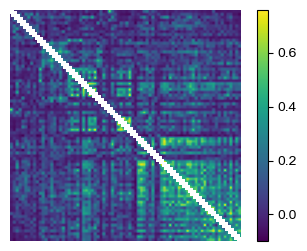

In [43]:
def get_lapwise_ratemap_R7(trace: dict):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    smoothed_map = np.zeros((trace['n_neuron'], 144, beg_idx.shape[0]), dtype = np.float64)
    
    for i in range(beg_idx.shape[0]):
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = spike_nodes_transform(trace['spike_nodes_original'][spike_idx].astype(np.int64), 12)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        rate_map = spike_train.calc_tuning_curve(144, t_interv_limits=100)
        smoothed_map[:, :, i] = rate_map.to_array() #@ trace['Ms'].T
    
    bins = CP_DSP[6]-1
    smoothed_map = smoothed_map[:, bins, :]

    X = np.transpose(smoothed_map, (2, 1, 0))
    return X

def get_all_mice_data_R7(mouse):
    file_indices = np.where(f2['MiceID'] == mouse)[0]
    cellreg_index = np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]
    
    traces = []
    for i in file_indices:
        with open(f2['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)
            traces.append(trace)

    with open(f_CellReg_dsp['cellreg_folder'][cellreg_index], 'rb') as handle:
        index_map = pickle.load(handle).astype(np.int64)
            
    if mouse != 10232:
        index_map = index_map[1:, :]
    
    # Identify neurons that appear in all sessions
    ncell = np.where(np.sum(np.where(index_map == 0, 0, 1), axis=0) == index_map.shape[0])[0]
    
    session_label = []
    route_label = []
    Xs = []
    centroid_init0 = []
    centroid_init1 = []
    for i, trace in enumerate(traces):
        X = get_lapwise_ratemap_R7(trace)
        
        cent1 = trace[f'node 3']['old_map_clear'][index_map[i, ncell]-1, :][:, CP_DSP[3]-1].T.flatten()
        cent0 = np.vstack([trace[f'node {n}']['old_map_clear'][index_map[i, ncell]-1, :][:, CP_DSP[3]-1].T.flatten() for n in [0, 4, 5, 9]])
        cent0 = np.mean(cent0, axis=0)
        
        centroid_init0.append(cent0)
        centroid_init1.append(cent1)
        
        beg_time, end_time = trace['lap beg time'], trace['lap end time']
        beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
        Xs.append(X[:, :, index_map[i, ncell]-1])
        
        session_label.append(np.ones(X.shape[0])*i)
        route_label.append(routes)
    
    return np.concatenate(Xs, axis=0), np.concatenate(session_label), np.concatenate(route_label), [centroid_init0, centroid_init1]

mouse = 10232
if exists(join(loc, f"{mouse}_R7.pkl")) == False:
    if exists(join(loc, f"{mouse}.pkl")) == False:
        X, session_label, route_label, kmeans_init = get_all_mice_data(mouse)
    
        with open(join(loc, f"{mouse}.pkl"), "wb") as f:
            pickle.dump([X, session_label, route_label, kmeans_init], f)
    else:
        with open(join(loc, f"{mouse}.pkl"), "rb") as f:
            X, session_label, route_label, kmeans_init = pickle.load(f)
    X7, session_label7, route_label7, kmeans_init7 = get_all_mice_data_R7(mouse)
    with open(join(loc, f"{mouse}_R7.pkl"), "wb") as f:
        pickle.dump([[X, session_label, route_label, kmeans_init], [X7, session_label7, route_label7, kmeans_init7]], f)
else:
    with open(join(loc, f"{mouse}_R7.pkl"), "rb") as f:
        res4, res7 = pickle.load(f) 
        X, session_label, route_label, kmeans_init = res4
        X7, session_label7, route_label7, kmeans_init7 = res7

kmeans_init = np.vstack([np.mean(i, axis=0) for i in kmeans_init])
U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)

idx = np.where(route_label7 == 6)[0]
corr = np.corrcoef(X7[idx, 4, :], rowvar=True)
np.fill_diagonal(corr, np.nan)
fig = plt.figure(figsize=(4, 3))
ax = Clear_Axes(plt.axes())
im = ax.imshow(corr)
plt.colorbar(im, ax=ax)
plt.show()